# Importing required libraries

In [3]:
# Importing all required libraries

import pandas as pd
import numpy as np
import glob
import re
from scipy import signal
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
from collections import defaultdict
import random
import copy

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop

from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedGroupKFold

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

%matplotlib inline

In [4]:
pwd

'C:\\Users\\vss20\\Documents\\RWTH Aachen CAME\\Semester 3\\CIE\\CIE_project_A'

# Folders & Files list 

In [5]:
# File paths for Smartphone 1 & Smartphone 2 data folders

filepath_S1 = 'Smartphone1'
filepath_S2 = 'Smartphone2'

In [6]:
# Smartphone1

impaired_list_S1 = []
for x in glob.glob(filepath_S1+'/*imp*'):
    impaired_list_S1.append(x)

normal_list_S1 = []
for x in glob.glob(filepath_S1+'/*nor*'):
    normal_list_S1.append(x)
for x in glob.glob(filepath_S1+'/*straight*'):
    normal_list_S1.append(x)
    
# Smartphone2
impaired_list_S2 = []
for x in glob.glob(filepath_S2+'/*imp*'):
    impaired_list_S2.append(x)

normal_list_S2 = []
for x in glob.glob(filepath_S2+'/*nor*'):
    normal_list_S2.append(x)
for x in glob.glob(filepath_S2+'/*straight*'):
    normal_list_S2.append(x)

# Required function definitions

In [7]:
# Extracting the Subject No.:
def subjectextractor(filepath):
    
    pattern = r'\d\d\d'
    subject = int(re.search(pattern,filepath).group())
    
    return subject

# Finding the subject list, total number of subjects:
def tot_sub(*args):
    x = set()
    for i in args:
        for j in i:
            sub = subjectextractor(j)
            x.add(sub)

    return (x)

In [8]:
# Filer definition
# Cut off frequency and filter order are choosen as 5 as other choices allowing more noise 

def filter_data(sensordata, fs, fc=5):
    sensordata_filt = np.zeros(sensordata.shape)
    
    w = fc / (fs / 2)
    b, a = signal.butter(fc,w, 'low')
    
    sensordata_filt[:,0] = signal.filtfilt(b,a, sensordata[:,0])
    sensordata_filt[:,1] = signal.filtfilt(b,a, sensordata[:,1])
    sensordata_filt[:,2] = signal.filtfilt(b,a, sensordata[:,2])
    
    return sensordata_filt

In [9]:
# Extract the whole activity sequence by removing the noise

def cut_data(filt_acc, filt_gyro, fs):
    
    acc_abs  = np.linalg.norm(filt_acc,axis=1)
    gyro_abs = np.linalg.norm(filt_gyro,axis=1)
    
    #accelerometer
    
    acc_med        = np.median(acc_abs)
    acc_std        = np.std(acc_abs)
    acc_height     = round(acc_med+0.5*acc_std,2)
    acc_pks, _     = signal.find_peaks(acc_abs,height=acc_height)
    diff_acc_pks   = np.diff(acc_pks)
    acc_gap1       = np.argmax(diff_acc_pks[:int(0.2*acc_pks.shape[0])])
    acc_gap2       = np.argmax(diff_acc_pks[-int(0.1*acc_pks.shape[0]):])
    acc_gap2       = int(acc_gap2 + (np.shape(diff_acc_pks)[0])-int(0.1*acc_pks.shape[0]))

    # gyroscope
     
    gyro_med       = np.median(gyro_abs)
    gyro_std       = np.std(gyro_abs)
    gyro_height    = round(gyro_med+0.5*gyro_std,2)
    gyro_pks, _    = signal.find_peaks(gyro_abs,height=gyro_height)
    diff_gyro_pks  = np.diff(gyro_pks)
    gyro_gap1      = np.argmax(diff_gyro_pks[:int(0.2*gyro_pks.shape[0])])
    gyro_gap2      = np.argmax(diff_gyro_pks[-int(0.1*gyro_pks.shape[0]):])
    gyro_gap2      = int(gyro_gap2 + (np.shape(diff_gyro_pks)[0])-int(0.1*gyro_pks.shape[0]))
    
    
    acc_cut  = filt_acc[acc_pks[acc_gap1+1]:acc_pks[acc_gap2],:]
    gyro_cut = filt_gyro[gyro_pks[gyro_gap1+1]:gyro_pks[gyro_gap2],:] 
    
    min = np.minimum(acc_cut.shape[0],gyro_cut.shape[0])
    
    acc_cut  = acc_cut[:min,:]
    gyro_cut = gyro_cut[:min,:]
    
    return acc_cut, gyro_cut

In [10]:
# Rotation of data

def rot(cut_acc,gyro_cut):
    
    cols=['x','y','z']
    df_acc  = pd.DataFrame(data=cut_acc,columns=cols)
    df_gyro = pd.DataFrame(data=cut_gyro,columns=cols)
    
    scale = StandardScaler()

    #accelerometer data
    scale.fit(df_acc)
    scaled_df_acc = scale.transform(df_acc)

    #gyroscope data
    scale.fit(df_gyro)
    scaled_df_gyro = scale.fit_transform(df_gyro)
    
    # PCA
    pca = PCA()
    acc_mod  = pca.fit_transform(scaled_df_acc)
    gyro_mod = pca.fit_transform(scaled_df_gyro)
    
    return acc_mod, gyro_mod

In [16]:
# Resampling of data points
def resampling(acc,gyro,n_pnts):    
    med        = np.median(gyro[:,1])
    std        = np.std(gyro[:,1])
    height     = round(med+0.5*std,2)
 
    #print(str(fs) + ' is  the sampling freq')
    peaks,_    = signal.find_peaks(gyro[:,1],height=height,distance=fs/2)
    
    fin_acc  = np.empty((len(peaks),n_pnts,3))
    fin_gyro = np.empty((len(peaks),n_pnts,3))

    for k in range(len(peaks)-1):

        fin_acc[k,:,:]  = signal.resample(np.array([(acc[i]) for i in range(peaks[k],peaks[k+1])]),n_pnts)
        fin_gyro[k,:,:] = signal.resample(np.array([(gyro[i]) for i in range(peaks[k],peaks[k+1])]),n_pnts)
    
    
    return np.concatenate((fin_acc,fin_gyro),axis=2)

In [10]:
# Main program - Smartphone 1!

fin_data      = np.empty((1,50,6)) # X-data
y_label       = np.empty((1,1))    # Y-data
subject_label = np.empty((1,1))    # Subject-labels

for s in tot_sub(normal_list_S1,impaired_list_S1):

    nor = [nor for nor in normal_list_S1 if subjectextractor(nor)==s]
    imp = [imp for imp in impaired_list_S1 if subjectextractor(imp)==s]

    for filepath in (nor+imp):
        
        # Accelerometer & Gyroscope files
        
        acc_file  = filepath + '/Accelerometer.csv'
        gyro_file = filepath + '/Gyroscope.csv'

        try:
             # Reading Datas
            acc_data  = pd.read_csv(acc_file)
            acc_data = acc_data.dropna(axis=0)


        except FileNotFoundError:
            print(str(subjectextractor(filepath)) + ' has Accelerometer either missing record  or a wrong format')
            continue
        try:
             # Reading Datas
            gyro_data = pd.read_csv(gyro_file)
            gyro_data = gyro_data.dropna(axis=0)
            

        except FileNotFoundError:
            print(str(subjectextractor(filepath)) + ' has Gyroscope either missing record  or a wrong format')
            continue


        # Sensor readings
        acc  = acc_data.iloc[:,1:4].values.astype(float)
        gyro = gyro_data.iloc[:,1:4].values.astype(float)

        # Sampling frequency
        fs = np.round(len(acc_data)/(acc_data.iloc[-2,0]-acc_data.iloc[0,0]))
        
        # Filtering
        filt_acc  = filter_data(acc,fs)
        filt_gyro = filter_data(gyro,fs)
        
        # Motion extraction
        cut_acc,cut_gyro = cut_data(filt_acc,filt_gyro,fs)
        mod_acc,mod_gyro = rot(cut_acc,cut_gyro)

        # Resampling of each sequence to 50 polints
        sub_data = resampling(mod_acc,mod_gyro,50)

        num_elements = sub_data.shape[0]
        
        if np.sum(np.isnan(sub_data))>0:
            continue

        if filepath in normal_list_S1:
            y_label = np.concatenate((y_label,np.ones((num_elements,1))),axis=0)
    
        else:
            y_label = np.concatenate((y_label,np.zeros((num_elements,1))),axis=0)
        
        subject_label = np.concatenate((subject_label,np.ones((num_elements,1))*s),axis=0)
        
        fin_data = np.concatenate((fin_data,sub_data),axis=0)
        
fin_data      = fin_data[1:,:,:]
y_label       = y_label[1:]
subject_label = subject_label[1:]

162 has Gyroscope either missing record  or a wrong format
217 has Accelerometer either missing record  or a wrong format


In [17]:
print(fin_data.shape)
print(y_label.shape)
print(subject_label.shape)
print(fin_data.shape[0])
print(np.sum(np.isnan(fin_data)))

(12880, 50, 6)
(12880, 1)
(12880, 1)
12880
0


In [ ]:
(244,1,2)

In [18]:
# Main program - Smartphone 2!

fin_data2      = np.empty((1,50,6))  # X-data
y_label2       = np.empty((1,1))     # Y-data
subject_label2 = np.empty((1,1))     # Subject-labels

for s in tot_sub(normal_list_S2,impaired_list_S2):


    nor = [nor for nor in normal_list_S2 if subjectextractor(nor)==s]
    imp = [imp for imp in impaired_list_S2 if subjectextractor(imp)==s]

    for filepath in (nor+imp):


        # Accelerometer & Gyroscope files 
        acc_file  = filepath + '/Accelerometer.csv'
        gyro_file = filepath + '/Gyroscope.csv'

        try:
             # Reading Datas
            acc_data  = pd.read_csv(acc_file)
            acc_data  = acc_data.dropna(axis=0)


        except FileNotFoundError:
            print(str(subjectextractor(filepath)) + ' has Accelerometer either missing record  or a wrong format')
            continue
        try:
             # Reading Datas
            gyro_data = pd.read_csv(gyro_file)
            gyro_data = gyro_data.dropna(axis=0)
            

        except FileNotFoundError:
            print(str(subjectextractor(filepath)) + ' has Gyroscope either missing record  or a wrong format')
            continue

        # Sensor readings
        acc  = acc_data.iloc[:,1:4].values.astype(float)
        gyro = gyro_data.iloc[:,1:4].values.astype(float)

        # Sampling frequency
        fs = np.round(len(acc_data)/(acc_data.iloc[-2,0]-acc_data.iloc[0,0]))
        
        # Filtering
        filt_acc  = filter_data(acc,fs)
        filt_gyro = filter_data(gyro,fs)

        # Motion extraction
        cut_acc,cut_gyro = cut_data(filt_acc,filt_gyro,fs)
        mod_acc,mod_gyro = rot(cut_acc,cut_gyro)

        # Resampling of each sequence to 50 polints
        sub_data = resampling(mod_acc,mod_gyro,50)

        num_elements = sub_data.shape[0]
        
        if np.sum(np.isnan(sub_data))>0:
            continue
        
        if filepath in normal_list_S2:
            y_label2 = np.concatenate((y_label2,np.ones((num_elements,1))),axis=0)
    
        else:
            y_label2 = np.concatenate((y_label2,np.zeros((num_elements,1))),axis=0)
        
        subject_label2 = np.concatenate((subject_label2,np.ones((num_elements,1))*s),axis=0)
        

        
        fin_data2 = np.concatenate((fin_data2,sub_data),axis=0)
        
fin_data2      = fin_data2[1:,:,:]
y_label2       = y_label2[1:]
subject_label2 = subject_label2[1:]

In [19]:
print(fin_data2.shape)
print(y_label2.shape)
print(subject_label2.shape)
print(fin_data2.shape[0])
print(np.sum(np.isnan(fin_data2)))

(12014, 50, 6)
(12014, 1)
(12014, 1)
12014
0


# Splitting into Train / Test Datasets  
# Smartphone 1

In [20]:
idx = random.sample(range(fin_data.shape[0]),int(0.2*fin_data.shape[0]))

k = np.take(fin_data,idx,axis=0)
m = np.take(y_label,idx,axis=0)
n = np.take(subject_label,idx,axis=0)

test_y_label = copy.deepcopy(m)
test_data = copy.deepcopy(k)
test_subject_label = copy.deepcopy(n)


train_data  = np.delete(fin_data,idx,axis=0)
train_y_label = np.delete(y_label,idx,axis=0)
train_subject_label = np.delete(subject_label,idx,axis=0)

In [21]:
print(train_subject_label)
print(train_data)
print(train_data.shape)
print(train_y_label.shape)
print(train_subject_label.shape)
print(np.sum(np.isnan(train_data)))
print(test_data.shape)
print(test_y_label.shape)
print(np.sum(np.isnan(test_data)))

[[150.]
 [150.]
 [150.]
 ...
 [274.]
 [274.]
 [274.]]
[[[ 2.37549758e-01  5.36789489e-01 -2.20387983e+00  3.29090045e-01
    2.51454353e+00 -1.58956239e+00]
  [-3.45684633e+00 -3.78020069e-01 -1.46429712e+00 -7.06615970e-01
    7.96048532e-02 -1.03873752e-01]
  [-1.34855278e+00 -5.77091676e-01 -2.52793993e+00 -8.93506213e-01
    3.83010250e-01 -5.61729151e-01]
  ...
  [ 2.60062194e+00  4.32909724e-01 -6.79635361e-01  2.37453786e+00
    2.73231707e+00 -1.26110697e+00]
  [ 3.13892099e+00  7.99711636e-01 -2.13463135e+00  2.20125957e+00
    3.46811721e+00 -1.91053713e+00]
  [ 4.74157203e+00  1.33921433e+00 -3.61651423e+00  1.73873378e+00
    4.88722913e+00 -3.13452323e+00]]

 [[ 1.76845268e+00  1.44074008e+00 -2.07639325e+00  6.07888055e-01
    3.90067380e+00 -2.61966481e+00]
  [ 4.08427884e+00  1.18592791e+00 -3.76428580e+00  2.84723052e-01
    4.82324422e+00 -3.43479319e+00]
  [ 2.72120504e+00  1.00785150e+00 -2.80773202e+00 -1.99764260e-01
    4.01078269e+00 -2.97140248e+00]
  ...
  [-1

# Smartphone 2

In [22]:
idx = random.sample(range(fin_data2.shape[0]),int(0.2*fin_data2.shape[0]))

k = np.take(fin_data2,idx,axis=0)
m = np.take(y_label2,idx,axis=0)
n = np.take(subject_label2,idx,axis=0)

test_y_label2       = copy.deepcopy(m)
test_data2          = copy.deepcopy(k)
test_subject_label2 = copy.deepcopy(n)


train_data2          = np.delete(fin_data2,idx,axis=0)
train_y_label2       = np.delete(y_label2,idx,axis=0)
train_subject_label2 = np.delete(subject_label2,idx,axis=0)

In [23]:
print(train_subject_label2)
print(train_data2)
print(train_data2.shape)
print(train_y_label2.shape)
print(train_subject_label2.shape)
print(np.sum(np.isnan(train_data2)))
print(np.sum(np.isnan(train_data2)))
print(test_data2.shape)
print(test_y_label2.shape)
print(np.sum(np.isnan(test_data2)))

[[150.]
 [150.]
 [150.]
 ...
 [274.]
 [274.]
 [274.]]
[[[-0.52199552 -0.27393465 -0.78345149  0.4106246   1.42902679
   -0.14821935]
  [ 0.10507354 -0.92228761 -1.76877962 -1.2794203   1.57287487
    0.69941185]
  [-0.03386448 -0.73039204 -1.46738092 -0.82011273  1.49406982
    0.50133815]
  ...
  [-1.67669484  0.92008042  0.76124769  2.80556355  1.00235415
   -1.4027543 ]
  [-1.46177762  0.71966379  0.47917151  2.47927415  1.14491272
   -1.24007511]
  [-1.49141762  0.77215669  0.68492568  2.8916656   1.17877967
   -1.40179497]]

 [[-1.29371234 -0.54823141 -0.10119158  1.11600724  0.96936903
   -0.37093379]
  [-1.01625126  0.52914099  0.55008327  2.6240432   1.24550294
   -1.14855683]
  [-0.81715068  0.01028539  0.38512027  1.99975201  1.02434261
   -0.7229837 ]
  ...
  [-1.42877684 -0.86859595 -1.02348779 -1.13734624  0.25234834
    0.28923514]
  [-1.41461066 -1.12191787 -0.89469551 -0.7740254   0.48624583
    0.29430194]
  [-1.44216759 -1.90614036 -1.03010422 -1.12325724  0.50774674


# Hyperparameter Tuning

In [46]:
def my_model(n_units=16,activation='relu',lrate=1e-3):
    
    model = Sequential()
    model.add(tfl.Input(shape=(50,6)))
    model.add(tfl.Flatten())
    model.add(tfl.Dense(units=n_units,activation=activation))
    model.add(tfl.Dense(units=1,activation='sigmoid'))
    
    # Model Compile
    model.compile(optimizer=Adam(learning_rate=lrate),loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [47]:
model       = KerasClassifier(build_fn=my_model,verbose=1)
no_units    = [8,16,32,64,128]
activations = ['sigmoid','tanh']
epochs      = [15]
batchsize   = [8,16,32]
lrates      = [0.001,0.003,0.01]

param_grid  = dict(n_units = no_units,activation=activations,
                  lrate=lrates,epochs=epochs,batch_size=batchsize)

<ipython-input-47-f1133d0b07d3>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model       = KerasClassifier(build_fn=my_model,verbose=1)


In [48]:
param_grid

{'n_units': [8, 16, 32, 64, 128],
 'activation': ['sigmoid', 'tanh'],
 'lrate': [0.001, 0.003, 0.01],
 'epochs': [15],
 'batch_size': [8, 16, 32]}

In [40]:
grid = GridSearchCV(estimator=model,param_grid=param_grid)
grid_result = grid.fit(train_data,train_y_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.6750 - accuracy: 0.5650
Epoch 2/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.6486 - accuracy: 0.6157
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.6295 - accuracy: 0.6479
Epoch 4/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.6106 - accuracy: 0.6678
Epoch 5/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5930 - accuracy: 0.6887
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5763 - accuracy: 0.7061
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5598 - accuracy: 0.7226
Epoch 8/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5475 - accuracy: 0.7310
Epoch 9/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5348 - accuracy: 0.7416
Epoch 10/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.523

258/258 [==============================] - 0s 1ms/step - loss: 0.7770 - accuracy: 0.5714
Epoch 1/15
1031/1031 [==============================] - 3s 2ms/step - loss: 0.6698 - accuracy: 0.5929
Epoch 2/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.6093 - accuracy: 0.6746
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5542 - accuracy: 0.7338
Epoch 4/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.5021 - accuracy: 0.7771
Epoch 5/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4561 - accuracy: 0.8086: 0s - loss: 0.4590 - ac
Epoch 6/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.4183 - accuracy: 0.8310
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3873 - accuracy: 0.8428
Epoch 8/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3620 - accuracy: 0.8584
Epoch 9/15
1031/1031 [==============================] - 2s 2ms/step - l

258/258 [==============================] - 1s 2ms/step - loss: 0.9181 - accuracy: 0.5723
Epoch 1/15
1031/1031 [==============================] - 3s 2ms/step - loss: 0.6662 - accuracy: 0.6005
Epoch 2/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5765 - accuracy: 0.7031
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4805 - accuracy: 0.7902
Epoch 4/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3897 - accuracy: 0.8440
Epoch 5/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3153 - accuracy: 0.8884
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2593 - accuracy: 0.9145
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2148 - accuracy: 0.9325
Epoch 8/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.1813 - accuracy: 0.9477
Epoch 9/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.1526 - accuracy: 

258/258 [==============================] - 0s 1ms/step - loss: 0.8374 - accuracy: 0.5602
Epoch 1/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.6619 - accuracy: 0.6077
Epoch 2/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5819 - accuracy: 0.6980
Epoch 3/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.5204 - accuracy: 0.7518
Epoch 4/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.4785 - accuracy: 0.7770
Epoch 5/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.4499 - accuracy: 0.7996
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4257 - accuracy: 0.8109
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4096 - accuracy: 0.8174
Epoch 8/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3964 - accuracy: 0.8252
Epoch 9/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3844 - accuracy: 

258/258 [==============================] - 1s 1ms/step - loss: 1.1482 - accuracy: 0.5456
Epoch 1/15
1031/1031 [==============================] - 3s 2ms/step - loss: 0.6430 - accuracy: 0.6291
Epoch 2/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4920 - accuracy: 0.7745
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3815 - accuracy: 0.8400
Epoch 4/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3085 - accuracy: 0.8754
Epoch 5/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.2530 - accuracy: 0.9049
Epoch 6/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.2145 - accuracy: 0.9215
Epoch 7/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.1892 - accuracy: 0.9301
Epoch 8/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.1727 - accuracy: 0.9370
Epoch 9/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.1514 - accuracy: 

258/258 [==============================] - 1s 1ms/step - loss: 1.4193 - accuracy: 0.5544
Epoch 1/15
1031/1031 [==============================] - 3s 2ms/step - loss: 0.6561 - accuracy: 0.6156
Epoch 2/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5995 - accuracy: 0.6837
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5691 - accuracy: 0.7131
Epoch 4/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5532 - accuracy: 0.7273
Epoch 5/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5384 - accuracy: 0.7340
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5325 - accuracy: 0.7395
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5228 - accuracy: 0.7445
Epoch 8/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5130 - accuracy: 0.7542
Epoch 9/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5166 - accuracy: 

258/258 [==============================] - 0s 1ms/step - loss: 0.9111 - accuracy: 0.5626
Epoch 1/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.6381 - accuracy: 0.6337
Epoch 2/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5374 - accuracy: 0.7346
Epoch 3/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.4799 - accuracy: 0.7697
Epoch 4/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.4501 - accuracy: 0.7924
Epoch 5/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.4238 - accuracy: 0.8049
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4045 - accuracy: 0.8201
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3976 - accuracy: 0.8231
Epoch 8/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3774 - accuracy: 0.8337
Epoch 9/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.3655 - accuracy: 

1031/1031 [==============================] - 2s 2ms/step - loss: 0.2703 - accuracy: 0.8869
Epoch 13/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2529 - accuracy: 0.8931
Epoch 14/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2407 - accuracy: 0.8982
Epoch 15/15
258/258 [==============================] - 0s 1ms/step - loss: 1.1606 - accuracy: 0.5684
Epoch 1/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.6328 - accuracy: 0.6413
Epoch 2/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4868 - accuracy: 0.7656
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4033 - accuracy: 0.8175
Epoch 4/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3451 - accuracy: 0.8508
Epoch 5/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3260 - accuracy: 0.8555
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2765 - accurac

516/516 [==============================] - 1s 2ms/step - loss: 0.5333 - accuracy: 0.7493
Epoch 13/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5259 - accuracy: 0.7576: 
Epoch 14/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5181 - accuracy: 0.7595
Epoch 15/15
129/129 [==============================] - 1s 1ms/step - loss: 0.7637 - accuracy: 0.5223
Epoch 1/15
516/516 [==============================] - 1s 2ms/step - loss: 0.6729 - accuracy: 0.5809
Epoch 2/15
516/516 [==============================] - 1s 2ms/step - loss: 0.6459 - accuracy: 0.6285
Epoch 3/15
516/516 [==============================] - 1s 2ms/step - loss: 0.6228 - accuracy: 0.6604
Epoch 4/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5978 - accuracy: 0.6933
Epoch 5/15
516/516 [==============================] - 1s 1ms/step - loss: 0.5699 - accuracy: 0.7207
Epoch 6/15
516/516 [==============================] - 1s 1ms/step - loss: 0.5439 - accuracy: 0.7445
Epoch 

516/516 [==============================] - 1s 1ms/step - loss: 0.3056 - accuracy: 0.8866
Epoch 15/15
129/129 [==============================] - 0s 1ms/step - loss: 0.8004 - accuracy: 0.5796
Epoch 1/15
516/516 [==============================] - 2s 2ms/step - loss: 0.6696 - accuracy: 0.5857
Epoch 2/15
516/516 [==============================] - 1s 2ms/step - loss: 0.6153 - accuracy: 0.6642
Epoch 3/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5637 - accuracy: 0.7177
Epoch 4/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5076 - accuracy: 0.7733: 0s - loss: 0.5109 - accuracy: 
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4544 - accuracy: 0.8131: 1s - l
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4072 - accuracy: 0.8447: 0s - loss: 0.4079 - accura
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3675 - accuracy: 0.8661
Epoch 8/15
516/516 [======================

516/516 [==============================] - 1s 2ms/step - loss: 0.1286 - accuracy: 0.9720
Epoch 15/15
129/129 [==============================] - 0s 1ms/step - loss: 0.9144 - accuracy: 0.5621
Epoch 1/15
516/516 [==============================] - 2s 2ms/step - loss: 0.6678 - accuracy: 0.5936
Epoch 2/15
516/516 [==============================] - 1s 2ms/step - loss: 0.6140 - accuracy: 0.6711
Epoch 3/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5728 - accuracy: 0.7067
Epoch 4/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5409 - accuracy: 0.7337
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5204 - accuracy: 0.7506
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5007 - accuracy: 0.7640
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4872 - accuracy: 0.7730
Epoch 8/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4769 - accuracy: 0.7770
Epoch 9/15

516/516 [==============================] - 1s 2ms/step - loss: 0.3405 - accuracy: 0.8538: 0s - loss: 0.3339 - accu
Epoch 14/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3307 - accuracy: 0.8576
Epoch 15/15
129/129 [==============================] - 1s 2ms/step - loss: 0.8266 - accuracy: 0.5927
Epoch 1/15
516/516 [==============================] - 2s 2ms/step - loss: 0.6530 - accuracy: 0.6164
Epoch 2/15
516/516 [==============================] - 1s 3ms/step - loss: 0.5553 - accuracy: 0.7270
Epoch 3/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4707 - accuracy: 0.7919
Epoch 4/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4141 - accuracy: 0.8287
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3694 - accuracy: 0.8481
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3348 - accuracy: 0.8672
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3114 - 

516/516 [==============================] - 1s 2ms/step - loss: 0.1128 - accuracy: 0.9639
Epoch 15/15
129/129 [==============================] - 0s 1ms/step - loss: 1.1003 - accuracy: 0.5757
Epoch 1/15
516/516 [==============================] - 1s 2ms/step - loss: 0.6483 - accuracy: 0.6238
Epoch 2/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5036 - accuracy: 0.7622
Epoch 3/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3687 - accuracy: 0.8485
Epoch 4/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2808 - accuracy: 0.8941
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2150 - accuracy: 0.9250
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.1682 - accuracy: 0.9446
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.1354 - accuracy: 0.9591
Epoch 8/15
516/516 [==============================] - 1s 2ms/step - loss: 0.1084 - accuracy: 0.9711
Epoch 9/15

516/516 [==============================] - 1s 2ms/step - loss: 0.6496 - accuracy: 0.6169
Epoch 2/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5593 - accuracy: 0.7119
Epoch 3/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5112 - accuracy: 0.7497
Epoch 4/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4803 - accuracy: 0.7727
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4676 - accuracy: 0.7811
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4574 - accuracy: 0.7842
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4372 - accuracy: 0.7966
Epoch 8/15
516/516 [==============================] - 1s 1ms/step - loss: 0.4294 - accuracy: 0.7998
Epoch 9/15
516/516 [==============================] - 1s 1ms/step - loss: 0.4244 - accuracy: 0.8048
Epoch 10/15
516/516 [==============================] - 1s 1ms/step - loss: 0.4193 - accuracy: 0.8117
Epoch 11/1

Epoch 4/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3570 - accuracy: 0.8424: 0s - loss: 0.3538 
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3198 - accuracy: 0.8642
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2894 - accuracy: 0.8765
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2684 - accuracy: 0.8850
Epoch 8/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2550 - accuracy: 0.8942
Epoch 9/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2428 - accuracy: 0.9009
Epoch 10/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2335 - accuracy: 0.9062
Epoch 11/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2238 - accuracy: 0.9067
Epoch 12/15
516/516 [==============================] - 1s 1ms/step - loss: 0.2153 - accuracy: 0.9116
Epoch 13/15
516/516 [==============================] - 1s 2ms/step - loss: 0.

258/258 [==============================] - 0s 2ms/step - loss: 0.6087 - accuracy: 0.6717
Epoch 8/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5983 - accuracy: 0.6859
Epoch 9/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5887 - accuracy: 0.6953
Epoch 10/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5791 - accuracy: 0.7063
Epoch 11/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5702 - accuracy: 0.7114
Epoch 12/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5624 - accuracy: 0.7216
Epoch 13/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5560 - accuracy: 0.7255
Epoch 14/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5489 - accuracy: 0.7310
Epoch 15/15
65/65 [==============================] - 0s 2ms/step - loss: 0.7642 - accuracy: 0.5177
Epoch 1/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6794 - accuracy: 0.5675
Epoch 2

258/258 [==============================] - 1s 2ms/step - loss: 0.4203 - accuracy: 0.8390
Epoch 11/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4002 - accuracy: 0.8476
Epoch 12/15
258/258 [==============================] - 1s 2ms/step - loss: 0.3818 - accuracy: 0.8575
Epoch 13/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3653 - accuracy: 0.8652
Epoch 14/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8735
Epoch 15/15
65/65 [==============================] - 0s 2ms/step - loss: 0.8162 - accuracy: 0.5197
Epoch 1/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6768 - accuracy: 0.5735
Epoch 2/15
258/258 [==============================] - 0s 2ms/step - loss: 0.6465 - accuracy: 0.6271
Epoch 3/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6206 - accuracy: 0.6612
Epoch 4/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5929 - accuracy: 0.6983
Epoch 5/

258/258 [==============================] - 1s 2ms/step - loss: 0.1753 - accuracy: 0.9562
Epoch 15/15
65/65 [==============================] - 0s 3ms/step - loss: 0.9044 - accuracy: 0.5410
Epoch 1/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6742 - accuracy: 0.5802
Epoch 2/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6263 - accuracy: 0.6564: 0s - loss: 0.6313 - accuracy: 
Epoch 3/15
258/258 [==============================] - 1s 2ms/step - loss: 0.5778 - accuracy: 0.7087
Epoch 4/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5252 - accuracy: 0.7586
Epoch 5/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4725 - accuracy: 0.8010
Epoch 6/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.8346
Epoch 7/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3810 - accuracy: 0.8550
Epoch 8/15
258/258 [==============================] - 1s 2ms/step - loss: 0.3450

258/258 [==============================] - 1s 2ms/step - loss: 0.6837 - accuracy: 0.5727
Epoch 2/15
258/258 [==============================] - 0s 1ms/step - loss: 0.6346 - accuracy: 0.6371
Epoch 3/15
258/258 [==============================] - 0s 1ms/step - loss: 0.5924 - accuracy: 0.6910
Epoch 4/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5484 - accuracy: 0.7392
Epoch 5/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5096 - accuracy: 0.7653
Epoch 6/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4785 - accuracy: 0.7882
Epoch 7/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4527 - accuracy: 0.8021
Epoch 8/15
258/258 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.8174
Epoch 9/15
258/258 [==============================] - 0s 1ms/step - loss: 0.4135 - accuracy: 0.8222
Epoch 10/15
258/258 [==============================] - 0s 1ms/step - loss: 0.3978 - accuracy: 0.8314
Epoch 11/1

Epoch 5/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3455 - accuracy: 0.8626
Epoch 6/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3030 - accuracy: 0.8877
Epoch 7/15
258/258 [==============================] - 0s 2ms/step - loss: 0.2661 - accuracy: 0.9028
Epoch 8/15
258/258 [==============================] - 0s 2ms/step - loss: 0.2331 - accuracy: 0.9179
Epoch 9/15
258/258 [==============================] - 0s 2ms/step - loss: 0.2089 - accuracy: 0.9295
Epoch 10/15
258/258 [==============================] - 0s 2ms/step - loss: 0.1884 - accuracy: 0.9387
Epoch 11/15
258/258 [==============================] - 0s 2ms/step - loss: 0.1702 - accuracy: 0.9490
Epoch 12/15
258/258 [==============================] - 0s 2ms/step - loss: 0.1542 - accuracy: 0.9543
Epoch 13/15
258/258 [==============================] - 0s 2ms/step - loss: 0.1423 - accuracy: 0.9601
Epoch 14/15
258/258 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.

258/258 [==============================] - 0s 2ms/step - loss: 0.4918 - accuracy: 0.7642
Epoch 9/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4808 - accuracy: 0.7725
Epoch 10/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4752 - accuracy: 0.7720
Epoch 11/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4736 - accuracy: 0.7780
Epoch 12/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7819
Epoch 13/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.7799
Epoch 14/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4634 - accuracy: 0.7828
Epoch 15/15
65/65 [==============================] - 0s 1ms/step - loss: 0.8704 - accuracy: 0.5522
Epoch 1/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6584 - accuracy: 0.6125
Epoch 2/15
258/258 [==============================] - 0s 1ms/step - loss: 0.6026 - accuracy: 0.6762
Epoch 3

258/258 [==============================] - 0s 2ms/step - loss: 0.3872 - accuracy: 0.8235
Epoch 11/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3835 - accuracy: 0.8257
Epoch 12/15
258/258 [==============================] - 0s 1ms/step - loss: 0.3709 - accuracy: 0.8348
Epoch 13/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3701 - accuracy: 0.8373
Epoch 14/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3597 - accuracy: 0.8420
Epoch 15/15
65/65 [==============================] - 0s 1ms/step - loss: 1.0378 - accuracy: 0.5400
Epoch 1/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6558 - accuracy: 0.6173
Epoch 2/15
258/258 [==============================] - 1s 2ms/step - loss: 0.5684 - accuracy: 0.7091
Epoch 3/15
258/258 [==============================] - 1s 2ms/step - loss: 0.5212 - accuracy: 0.7457
Epoch 4/15
258/258 [==============================] - 1s 2ms/step - loss: 0.4943 - accuracy: 0.7630
Epoch 5/

Epoch 12/15
258/258 [==============================] - 0s 2ms/step - loss: 0.2699 - accuracy: 0.8872
Epoch 13/15
258/258 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.8925
Epoch 14/15
258/258 [==============================] - 1s 2ms/step - loss: 0.2576 - accuracy: 0.8935
Epoch 15/15
65/65 [==============================] - 0s 1ms/step - loss: 1.2117 - accuracy: 0.5279
Epoch 1/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6473 - accuracy: 0.6261
Epoch 2/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5287 - accuracy: 0.7377
Epoch 3/15
258/258 [==============================] - 1s 2ms/step - loss: 0.4537 - accuracy: 0.7939
Epoch 4/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4102 - accuracy: 0.8160
Epoch 5/15
258/258 [==============================] - 0s 1ms/step - loss: 0.3771 - accuracy: 0.8283
Epoch 6/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3545 - accuracy: 0.842

258/258 [==============================] - 0s 2ms/step - loss: 0.1000 - accuracy: 0.9631
Epoch 15/15
65/65 [==============================] - 0s 2ms/step - loss: 1.3846 - accuracy: 0.5570
Epoch 1/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6439 - accuracy: 0.6273
Epoch 2/15
258/258 [==============================] - 0s 2ms/step - loss: 0.4793 - accuracy: 0.7707
Epoch 3/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3736 - accuracy: 0.8334
Epoch 4/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3005 - accuracy: 0.8750
Epoch 5/15
258/258 [==============================] - 1s 2ms/step - loss: 0.2488 - accuracy: 0.8981
Epoch 6/15
258/258 [==============================] - 0s 2ms/step - loss: 0.2144 - accuracy: 0.9184
Epoch 7/15
258/258 [==============================] - 1s 2ms/step - loss: 0.1851 - accuracy: 0.9287
Epoch 8/15
258/258 [==============================] - 1s 2ms/step - loss: 0.1548 - accuracy: 0.9446: 0s - loss: 

1031/1031 [==============================] - 1s 1ms/step - loss: 0.3465 - accuracy: 0.8521
Epoch 15/15
258/258 [==============================] - 0s 1ms/step - loss: 1.0029 - accuracy: 0.5361
Epoch 1/15
1031/1031 [==============================] - 3s 2ms/step - loss: 0.6571 - accuracy: 0.6210
Epoch 2/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5681 - accuracy: 0.7111
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5162 - accuracy: 0.7540
Epoch 4/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4773 - accuracy: 0.7796
Epoch 5/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4482 - accuracy: 0.7955
Epoch 6/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.4319 - accuracy: 0.8023
Epoch 7/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.4138 - accuracy: 0.8106
Epoch 8/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.3999 - accuracy:

1031/1031 [==============================] - 2s 2ms/step - loss: 0.0983 - accuracy: 0.9708
Epoch 15/15
258/258 [==============================] - 1s 1ms/step - loss: 1.5265 - accuracy: 0.5143
Epoch 1/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.6204 - accuracy: 0.6544
Epoch 2/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.4711 - accuracy: 0.7819
Epoch 3/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.3799 - accuracy: 0.8374
Epoch 4/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.3150 - accuracy: 0.8725
Epoch 5/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2691 - accuracy: 0.8953
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2308 - accuracy: 0.9162
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.1978 - accuracy: 0.9328
Epoch 8/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.1766 - accuracy:

1031/1031 [==============================] - 2s 2ms/step - loss: 0.4672 - accuracy: 0.7773
Epoch 15/15
258/258 [==============================] - 0s 966us/step - loss: 0.8239 - accuracy: 0.5531
Epoch 1/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.6493 - accuracy: 0.6171
Epoch 2/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5865 - accuracy: 0.6920
Epoch 3/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5614 - accuracy: 0.7162
Epoch 4/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5453 - accuracy: 0.7317
Epoch 5/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5302 - accuracy: 0.7401
Epoch 6/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5226 - accuracy: 0.7441
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5116 - accuracy: 0.7502
Epoch 8/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.5065 - accurac

1031/1031 [==============================] - 1s 1ms/step - loss: 0.2519 - accuracy: 0.8966
Epoch 15/15
258/258 [==============================] - 0s 939us/step - loss: 1.3537 - accuracy: 0.4964
Epoch 1/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.6236 - accuracy: 0.6510
Epoch 2/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5032 - accuracy: 0.7541
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4527 - accuracy: 0.7861
Epoch 4/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4080 - accuracy: 0.8143
Epoch 5/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.3836 - accuracy: 0.8272
Epoch 6/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.3607 - accuracy: 0.8367
Epoch 7/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.3531 - accuracy: 0.8468
Epoch 8/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.3318 - accurac

1031/1031 [==============================] - 2s 2ms/step - loss: 0.1294 - accuracy: 0.9521
Epoch 14/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.1170 - accuracy: 0.9561
Epoch 15/15
258/258 [==============================] - 1s 2ms/step - loss: 1.7154 - accuracy: 0.5376
Epoch 1/15
1031/1031 [==============================] - 3s 2ms/step - loss: 0.6094 - accuracy: 0.6716
Epoch 2/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4300 - accuracy: 0.8035
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.3410 - accuracy: 0.8547
Epoch 4/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2940 - accuracy: 0.8771
Epoch 5/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2436 - accuracy: 0.8992
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2223 - accuracy: 0.9089
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.1930 - accuracy

1031/1031 [==============================] - 2s 2ms/step - loss: 0.5173 - accuracy: 0.7480
Epoch 14/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5194 - accuracy: 0.7438
Epoch 15/15
258/258 [==============================] - 1s 1ms/step - loss: 0.8782 - accuracy: 0.4944
Epoch 1/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.6688 - accuracy: 0.6040
Epoch 2/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.6297 - accuracy: 0.6481
Epoch 3/15
1031/1031 [==============================] - 2s 1ms/step - loss: 0.6001 - accuracy: 0.6786
Epoch 4/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5852 - accuracy: 0.6904
Epoch 5/15
1031/1031 [==============================] - 1s 1ms/step - loss: 0.5726 - accuracy: 0.6994
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5605 - accuracy: 0.7126
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5514 - accuracy

1031/1031 [==============================] - 3s 3ms/step - loss: 0.4483 - accuracy: 0.7927
Epoch 14/15
1031/1031 [==============================] - 3s 2ms/step - loss: 0.4355 - accuracy: 0.7939
Epoch 15/15
258/258 [==============================] - 1s 2ms/step - loss: 0.9408 - accuracy: 0.5332
Epoch 1/15
1031/1031 [==============================] - 3s 2ms/step - loss: 0.6601 - accuracy: 0.6123
Epoch 2/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5960 - accuracy: 0.6791
Epoch 3/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5624 - accuracy: 0.7119
Epoch 4/15
1031/1031 [==============================] - 3s 3ms/step - loss: 0.5420 - accuracy: 0.7338
Epoch 5/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5274 - accuracy: 0.7433
Epoch 6/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.5093 - accuracy: 0.7489
Epoch 7/15
1031/1031 [==============================] - 2s 2ms/step - loss: 0.4922 - accuracy

1031/1031 [==============================] - 4s 4ms/step - loss: 0.4329 - accuracy: 0.8078: 0s - loss: 0.4338 - accuracy: 0.
Epoch 8/15
1031/1031 [==============================] - 4s 4ms/step - loss: 0.4173 - accuracy: 0.8198
Epoch 9/15
1031/1031 [==============================] - 4s 3ms/step - loss: 0.4012 - accuracy: 0.8222
Epoch 10/15
1031/1031 [==============================] - 4s 4ms/step - loss: 0.3898 - accuracy: 0.8333: 0s - loss: 0.3897 - ac
Epoch 11/15
1031/1031 [==============================] - 4s 4ms/step - loss: 0.3889 - accuracy: 0.8309: 0s - loss: 0.3
Epoch 12/15
1031/1031 [==============================] - 6s 6ms/step - loss: 0.3702 - accuracy: 0.8416
Epoch 13/15
1031/1031 [==============================] - 5s 5ms/step - loss: 0.3654 - accuracy: 0.8450
Epoch 14/15
1031/1031 [==============================] - 4s 4ms/step - loss: 0.3563 - accuracy: 0.8484: 0s - loss: 0.3458 -  - ETA: 0s - loss: 0.3513 - accu
Epoch 15/15
258/258 [==============================] - 1s 3ms/

516/516 [==============================] - 2s 3ms/step - loss: 0.4888 - accuracy: 0.7782
Epoch 5/15
516/516 [==============================] - 2s 3ms/step - loss: 0.4571 - accuracy: 0.7987
Epoch 6/15
516/516 [==============================] - 2s 4ms/step - loss: 0.4338 - accuracy: 0.8058
Epoch 7/15
516/516 [==============================] - 2s 4ms/step - loss: 0.4140 - accuracy: 0.8195: 0s -
Epoch 8/15
516/516 [==============================] - 2s 3ms/step - loss: 0.3983 - accuracy: 0.8265
Epoch 9/15
516/516 [==============================] - 2s 4ms/step - loss: 0.3822 - accuracy: 0.8403
Epoch 10/15
516/516 [==============================] - 2s 3ms/step - loss: 0.3761 - accuracy: 0.8382
Epoch 11/15
516/516 [==============================] - 2s 4ms/step - loss: 0.3639 - accuracy: 0.8454: 0s - loss: 0.3
Epoch 12/15
516/516 [==============================] - 2s 4ms/step - loss: 0.3578 - accuracy: 0.8470
Epoch 13/15
516/516 [==============================] - 2s 4ms/step - loss: 0.3462 - ac

516/516 [==============================] - 2s 3ms/step - loss: 0.4932 - accuracy: 0.7704
Epoch 3/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4105 - accuracy: 0.8265
Epoch 4/15
516/516 [==============================] - 2s 3ms/step - loss: 0.3471 - accuracy: 0.8594
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2975 - accuracy: 0.8890
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2604 - accuracy: 0.9012
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2260 - accuracy: 0.9204
Epoch 8/15
516/516 [==============================] - 1s 2ms/step - loss: 0.2008 - accuracy: 0.9313
Epoch 9/15
516/516 [==============================] - 1s 2ms/step - loss: 0.1746 - accuracy: 0.9441
Epoch 10/15
516/516 [==============================] - 1s 2ms/step - loss: 0.1573 - accuracy: 0.9524
Epoch 11/15
516/516 [==============================] - 2s 4ms/step - loss: 0.1433 - accuracy: 0.9562
Epoch 12/

516/516 [==============================] - 1s 3ms/step - loss: 0.3620 - accuracy: 0.8527
Epoch 4/15
516/516 [==============================] - 2s 3ms/step - loss: 0.2855 - accuracy: 0.8922
Epoch 5/15
516/516 [==============================] - 1s 3ms/step - loss: 0.2327 - accuracy: 0.9192
Epoch 6/15
516/516 [==============================] - 2s 3ms/step - loss: 0.1859 - accuracy: 0.9436: 0s - loss: 0.1876 - accu
Epoch 7/15
516/516 [==============================] - 2s 3ms/step - loss: 0.1488 - accuracy: 0.9581
Epoch 8/15
516/516 [==============================] - 1s 3ms/step - loss: 0.1241 - accuracy: 0.9671
Epoch 9/15
516/516 [==============================] - 2s 3ms/step - loss: 0.0990 - accuracy: 0.9746
Epoch 10/15
516/516 [==============================] - 1s 3ms/step - loss: 0.0861 - accuracy: 0.9799
Epoch 11/15
516/516 [==============================] - 2s 3ms/step - loss: 0.0712 - accuracy: 0.9839
Epoch 12/15
516/516 [==============================] - 1s 3ms/step - loss: 0.0658 -

129/129 [==============================] - 0s 2ms/step - loss: 1.0649 - accuracy: 0.5497
Epoch 1/15
516/516 [==============================] - 2s 2ms/step - loss: 0.6453 - accuracy: 0.6273
Epoch 2/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5521 - accuracy: 0.7253
Epoch 3/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5018 - accuracy: 0.7580
Epoch 4/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4691 - accuracy: 0.7780: 0s - loss: 0.4696 - 
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4433 - accuracy: 0.7984
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4215 - accuracy: 0.8083
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4200 - accuracy: 0.8037
Epoch 8/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3986 - accuracy: 0.8184
Epoch 9/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3839 - accura

516/516 [==============================] - 1s 3ms/step - loss: 0.4489 - accuracy: 0.7933
Epoch 3/15
516/516 [==============================] - 1s 3ms/step - loss: 0.3734 - accuracy: 0.8338
Epoch 4/15
516/516 [==============================] - 2s 3ms/step - loss: 0.3168 - accuracy: 0.8636
Epoch 5/15
516/516 [==============================] - 2s 3ms/step - loss: 0.2839 - accuracy: 0.8837
Epoch 6/15
516/516 [==============================] - 1s 3ms/step - loss: 0.2517 - accuracy: 0.8983
Epoch 7/15
516/516 [==============================] - 2s 3ms/step - loss: 0.2208 - accuracy: 0.9124
Epoch 8/15
516/516 [==============================] - 2s 3ms/step - loss: 0.2030 - accuracy: 0.9208
Epoch 9/15
516/516 [==============================] - 1s 3ms/step - loss: 0.1827 - accuracy: 0.9304
Epoch 10/15
516/516 [==============================] - 2s 3ms/step - loss: 0.1664 - accuracy: 0.9383
Epoch 11/15
516/516 [==============================] - 1s 3ms/step - loss: 0.1611 - accuracy: 0.9376
Epoch 12/

516/516 [==============================] - 2s 2ms/step - loss: 0.6590 - accuracy: 0.6156
Epoch 2/15
516/516 [==============================] - 1s 2ms/step - loss: 0.6173 - accuracy: 0.6595
Epoch 3/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5989 - accuracy: 0.6777
Epoch 4/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5940 - accuracy: 0.6840
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5746 - accuracy: 0.7053
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5718 - accuracy: 0.7070
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5673 - accuracy: 0.7045
Epoch 8/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5664 - accuracy: 0.7051
Epoch 9/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5619 - accuracy: 0.7090
Epoch 10/15
516/516 [==============================] - 1s 2ms/step - loss: 0.5557 - accuracy: 0.7173
Epoch 11/1

516/516 [==============================] - 1s 2ms/step - loss: 0.5063 - accuracy: 0.7575
Epoch 5/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4757 - accuracy: 0.7756
Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4581 - accuracy: 0.7826
Epoch 7/15
516/516 [==============================] - 1s 3ms/step - loss: 0.4577 - accuracy: 0.7898
Epoch 8/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4380 - accuracy: 0.7970
Epoch 9/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4355 - accuracy: 0.7995: 0s - loss: 0.4324 - 
Epoch 10/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4267 - accuracy: 0.8020: 0s - l
Epoch 11/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4133 - accuracy: 0.8105
Epoch 12/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4019 - accuracy: 0.8190
Epoch 13/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4

Epoch 6/15
516/516 [==============================] - 1s 2ms/step - loss: 0.4137 - accuracy: 0.8129
Epoch 7/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3883 - accuracy: 0.8272
Epoch 8/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3853 - accuracy: 0.8271
Epoch 9/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3794 - accuracy: 0.8280: 
Epoch 10/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3610 - accuracy: 0.8425
Epoch 11/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3533 - accuracy: 0.8448
Epoch 12/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3467 - accuracy: 0.8527
Epoch 13/15
516/516 [==============================] - 1s 3ms/step - loss: 0.3428 - accuracy: 0.8503
Epoch 14/15
516/516 [==============================] - 1s 2ms/step - loss: 0.3241 - accuracy: 0.8609
Epoch 15/15
129/129 [==============================] - 1s 2ms/step - loss: 1.1271 - accuracy:

258/258 [==============================] - 1s 3ms/step - loss: 0.5333 - accuracy: 0.7397
Epoch 8/15
258/258 [==============================] - 1s 2ms/step - loss: 0.5243 - accuracy: 0.7511
Epoch 9/15
258/258 [==============================] - 1s 3ms/step - loss: 0.5177 - accuracy: 0.7509
Epoch 10/15
258/258 [==============================] - 1s 2ms/step - loss: 0.5093 - accuracy: 0.7549
Epoch 11/15
258/258 [==============================] - 1s 3ms/step - loss: 0.5030 - accuracy: 0.7657
Epoch 12/15
258/258 [==============================] - 1s 3ms/step - loss: 0.4970 - accuracy: 0.7655
Epoch 13/15
258/258 [==============================] - 1s 3ms/step - loss: 0.4919 - accuracy: 0.7687
Epoch 14/15
258/258 [==============================] - 1s 3ms/step - loss: 0.4872 - accuracy: 0.7733
Epoch 15/15
65/65 [==============================] - 0s 2ms/step - loss: 0.7830 - accuracy: 0.5580
Epoch 1/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6757 - accuracy: 0.5806
Epoch 2

258/258 [==============================] - 1s 4ms/step - loss: 0.3063 - accuracy: 0.8803: 0s - loss: 0.2
Epoch 10/15
258/258 [==============================] - 1s 3ms/step - loss: 0.2884 - accuracy: 0.8930
Epoch 11/15
258/258 [==============================] - 1s 4ms/step - loss: 0.2743 - accuracy: 0.8947
Epoch 12/15
258/258 [==============================] - 1s 4ms/step - loss: 0.2624 - accuracy: 0.9021
Epoch 13/15
258/258 [==============================] - 1s 5ms/step - loss: 0.2531 - accuracy: 0.9055
Epoch 14/15
258/258 [==============================] - 1s 4ms/step - loss: 0.2414 - accuracy: 0.9112
Epoch 15/15
65/65 [==============================] - 1s 3ms/step - loss: 0.9789 - accuracy: 0.5425
Epoch 1/15
258/258 [==============================] - 5s 6ms/step - loss: 0.6584 - accuracy: 0.6105
Epoch 2/15
258/258 [==============================] - 1s 6ms/step - loss: 0.5715 - accuracy: 0.7138: 1s - l
Epoch 3/15
258/258 [==============================] - 1s 3ms/step - loss: 0.5114 - 

258/258 [==============================] - 1s 2ms/step - loss: 0.2234 - accuracy: 0.9285
Epoch 7/15
258/258 [==============================] - 1s 3ms/step - loss: 0.1873 - accuracy: 0.9469
Epoch 8/15
258/258 [==============================] - 1s 3ms/step - loss: 0.1586 - accuracy: 0.9551
Epoch 9/15
258/258 [==============================] - 1s 3ms/step - loss: 0.1377 - accuracy: 0.9648
Epoch 10/15
258/258 [==============================] - 1s 3ms/step - loss: 0.1201 - accuracy: 0.9719
Epoch 11/15
258/258 [==============================] - 1s 3ms/step - loss: 0.1029 - accuracy: 0.9778
Epoch 12/15
258/258 [==============================] - 1s 2ms/step - loss: 0.0875 - accuracy: 0.9830
Epoch 13/15
258/258 [==============================] - 1s 2ms/step - loss: 0.0774 - accuracy: 0.9853
Epoch 14/15
258/258 [==============================] - 1s 2ms/step - loss: 0.0675 - accuracy: 0.9868
Epoch 15/15
65/65 [==============================] - 0s 2ms/step - loss: 1.1293 - accuracy: 0.5560
Epoch 1

258/258 [==============================] - 1s 3ms/step - loss: 0.3699 - accuracy: 0.8357
Epoch 11/15
258/258 [==============================] - 1s 2ms/step - loss: 0.3605 - accuracy: 0.8468
Epoch 12/15
258/258 [==============================] - 1s 2ms/step - loss: 0.3544 - accuracy: 0.8473
Epoch 13/15
258/258 [==============================] - 1s 2ms/step - loss: 0.3500 - accuracy: 0.8488
Epoch 14/15
258/258 [==============================] - 0s 2ms/step - loss: 0.3451 - accuracy: 0.8535
Epoch 15/15
65/65 [==============================] - 0s 1ms/step - loss: 1.0676 - accuracy: 0.5158
Epoch 1/15
258/258 [==============================] - 1s 2ms/step - loss: 0.6558 - accuracy: 0.6208
Epoch 2/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5550 - accuracy: 0.7226
Epoch 3/15
258/258 [==============================] - 0s 2ms/step - loss: 0.5061 - accuracy: 0.7552
Epoch 4/15
258/258 [==============================] - 1s 2ms/step - loss: 0.4788 - accuracy: 0.7770
Epoch 5/

258/258 [==============================] - 1s 3ms/step - loss: 0.1234 - accuracy: 0.9583
Epoch 14/15
258/258 [==============================] - 1s 2ms/step - loss: 0.1139 - accuracy: 0.9592
Epoch 15/15
65/65 [==============================] - 0s 2ms/step - loss: 1.4010 - accuracy: 0.5391
Epoch 1/15
258/258 [==============================] - 2s 3ms/step - loss: 0.6243 - accuracy: 0.6566
Epoch 2/15
258/258 [==============================] - 1s 4ms/step - loss: 0.4689 - accuracy: 0.7835
Epoch 3/15
258/258 [==============================] - 1s 3ms/step - loss: 0.3805 - accuracy: 0.8391
Epoch 4/15
258/258 [==============================] - 1s 3ms/step - loss: 0.3193 - accuracy: 0.8676
Epoch 5/15
258/258 [==============================] - 1s 3ms/step - loss: 0.2840 - accuracy: 0.8843: 0s - loss: 0.2840 - accuracy: 
Epoch 6/15
258/258 [==============================] - 1s 4ms/step - loss: 0.2437 - accuracy: 0.9040
Epoch 7/15
258/258 [==============================] - 1s 4ms/step - loss: 0.211

258/258 [==============================] - 1s 2ms/step - loss: 0.5457 - accuracy: 0.7255
Epoch 13/15
258/258 [==============================] - 1s 3ms/step - loss: 0.5379 - accuracy: 0.7366
Epoch 14/15
258/258 [==============================] - 1s 3ms/step - loss: 0.5335 - accuracy: 0.7340
Epoch 15/15
65/65 [==============================] - 1s 2ms/step - loss: 0.8714 - accuracy: 0.4915
Epoch 1/15
258/258 [==============================] - 2s 3ms/step - loss: 0.6686 - accuracy: 0.6123
Epoch 2/15
258/258 [==============================] - 1s 4ms/step - loss: 0.6052 - accuracy: 0.6714
Epoch 3/15
258/258 [==============================] - 1s 5ms/step - loss: 0.5844 - accuracy: 0.6948
Epoch 4/15
258/258 [==============================] - 1s 4ms/step - loss: 0.5600 - accuracy: 0.7119
Epoch 5/15
258/258 [==============================] - 1s 3ms/step - loss: 0.5539 - accuracy: 0.7188
Epoch 6/15
258/258 [==============================] - 1s 3ms/step - loss: 0.5490 - accuracy: 0.7169
Epoch 7/15

258/258 [==============================] - 1s 4ms/step - loss: 0.3905 - accuracy: 0.8249
Epoch 10/15
258/258 [==============================] - 1s 4ms/step - loss: 0.3746 - accuracy: 0.8305
Epoch 11/15
258/258 [==============================] - 1s 3ms/step - loss: 0.3690 - accuracy: 0.8354
Epoch 12/15
258/258 [==============================] - 1s 4ms/step - loss: 0.3600 - accuracy: 0.8411
Epoch 13/15
258/258 [==============================] - 1s 5ms/step - loss: 0.3561 - accuracy: 0.8425
Epoch 14/15
258/258 [==============================] - 1s 3ms/step - loss: 0.3568 - accuracy: 0.8356
Epoch 15/15
65/65 [==============================] - 0s 3ms/step - loss: 1.0933 - accuracy: 0.5158
Epoch 1/15
258/258 [==============================] - 1s 3ms/step - loss: 0.6384 - accuracy: 0.6419
Epoch 2/15
258/258 [==============================] - 1s 3ms/step - loss: 0.5473 - accuracy: 0.7213: 0s - loss: 0.5452 - accuracy
Epoch 3/15
258/258 [==============================] - 1s 3ms/step - loss: 0.5

258/258 [==============================] - 1s 3ms/step - loss: 0.2423 - accuracy: 0.9004
Epoch 11/15
258/258 [==============================] - 1s 3ms/step - loss: 0.2304 - accuracy: 0.9067
Epoch 12/15
258/258 [==============================] - 1s 3ms/step - loss: 0.2300 - accuracy: 0.9050
Epoch 13/15
258/258 [==============================] - 1s 3ms/step - loss: 0.2234 - accuracy: 0.9091: 0s - loss: 0.2187 - accuracy: 
Epoch 14/15
258/258 [==============================] - 1s 3ms/step - loss: 0.2326 - accuracy: 0.9023
Epoch 15/15
65/65 [==============================] - 0s 2ms/step - loss: 1.3556 - accuracy: 0.5328
Epoch 1/15
258/258 [==============================] - 2s 3ms/step - loss: 0.6383 - accuracy: 0.6462
Epoch 2/15
258/258 [==============================] - 1s 2ms/step - loss: 0.4798 - accuracy: 0.7673
Epoch 3/15
258/258 [==============================] - 1s 3ms/step - loss: 0.4252 - accuracy: 0.8049
Epoch 4/15
258/258 [==============================] - 1s 3ms/step - loss: 0.

In [42]:
grid_result.best_params_

{'activation': 'sigmoid',
 'batch_size': 8,
 'epochs': 15,
 'lrate': 0.001,
 'n_units': 128}

# Neural Net final model & Data Sets

In [24]:
# Smartphone 1

final_model = Sequential([

    tfl.Flatten(input_shape=(50,6)),
    tfl.Dense(units=128, activation='sigmoid'),
    tfl.Dropout(0.5),
    tfl.Dense(units=1,activation='sigmoid')

    ])

In [25]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 38,657
Trainable params: 38,657
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Smartphone 2

final_model2 = Sequential([

    tfl.Flatten(input_shape=(50,6)),
    tfl.Dense(units=128, activation='sigmoid'),
    tfl.Dropout(0.5),
    tfl.Dense(units=1,activation='sigmoid')

    ])

In [37]:
final_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               38528     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 38,657
Trainable params: 38,657
Non-trainable params: 0
_________________________________________________________________


# Performance of the Neural Network
# Training - 5 fold subject wise Cross Validation 
# + Testing

In [26]:
# Smartphone 1

n_splits = 5
cv = StratifiedGroupKFold(n_splits)

for train_idx, cv_idx in cv.split(X=train_data,y=train_y_label,groups=train_subject_label):
        
        training_data    = train_data[train_idx,:,:]
        training_y_label = train_y_label[train_idx]
        cv_data          = train_data[cv_idx,:,:]
        cv_y_label       = train_y_label[cv_idx]
        

        final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
        
        fin_model_history = final_model.fit(x=training_data,y=training_y_label,batch_size=8,epochs=15,shuffle=True,verbose=1,
          validation_data=(cv_data,cv_y_label)
         )

Epoch 1/15
1029/1029 [==============================] - 10s 7ms/step - loss: 0.7180 - accuracy: 0.5493 - val_loss: 0.7116 - val_accuracy: 0.5154
Epoch 2/15
1029/1029 [==============================] - 3s 3ms/step - loss: 0.6617 - accuracy: 0.6095 - val_loss: 0.7064 - val_accuracy: 0.5304
Epoch 3/15
1029/1029 [==============================] - 3s 3ms/step - loss: 0.6295 - accuracy: 0.6462 - val_loss: 0.6919 - val_accuracy: 0.5400
Epoch 4/15
1029/1029 [==============================] - 3s 3ms/step - loss: 0.5909 - accuracy: 0.6964 - val_loss: 0.6935 - val_accuracy: 0.5439
Epoch 5/15
1029/1029 [==============================] - 4s 4ms/step - loss: 0.5590 - accuracy: 0.7164 - val_loss: 0.6846 - val_accuracy: 0.5453
Epoch 6/15
1029/1029 [==============================] - 3s 3ms/step - loss: 0.5379 - accuracy: 0.7296 - val_loss: 0.6841 - val_accuracy: 0.5805
Epoch 7/15
1029/1029 [==============================] - 3s 3ms/step - loss: 0.5144 - accuracy: 0.7497 - val_loss: 0.7095 - val_accuracy

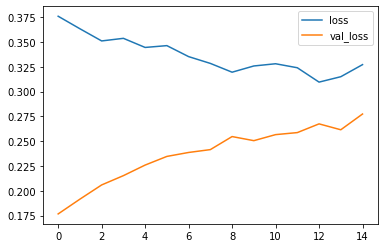

In [27]:
# Loss plots
plt.plot(fin_model_history.history['loss'])
plt.plot(fin_model_history.history['val_loss'])
plt.legend(['loss','val_loss'])

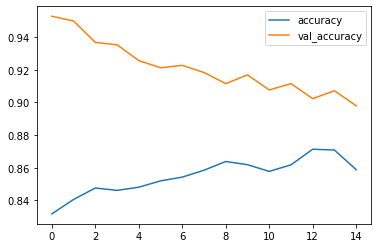

In [28]:
# Accuracy plots
plt.plot(fin_model_history.history['accuracy'])
plt.plot(fin_model_history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])

In [29]:
# Test Set Evaluation
final_model.evaluate(x=test_data,y=test_y_label,batch_size=8,verbose=2)

322/322 - 1s - loss: 0.3761 - accuracy: 0.8331 - 769ms/epoch - 2ms/step


[0.3760756552219391, 0.8330745100975037]

In [31]:
y_pred = np.round(final_model.predict(test_data))
y_pred

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

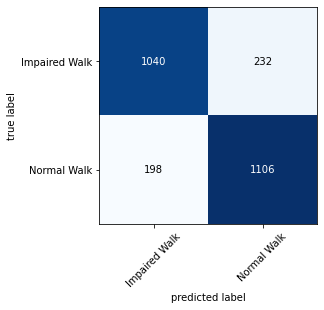

In [32]:
# Confusion Matrix Plot

conf_mat = confusion_matrix(test_y_label,y_pred)
plot_confusion_matrix(conf_mat,class_names=["Impaired Walk","Normal Walk"])

In [33]:
Acc_S1 = accuracy_score(test_y_label,y_pred)
print(Acc_S1)

0.8330745341614907


In [38]:
# Smartphone 2

n_splits = 5
cv = StratifiedGroupKFold(n_splits)

for train_idx, cv_idx in cv.split(X=train_data2,y=train_y_label2,groups=train_subject_label2):
        
        training_data2    = train_data2[train_idx,:,:]
        training_y_label2 = train_y_label2[train_idx]

        cv_data2          = train_data2[cv_idx,:,:]
        cv_y_label2       = train_y_label2[cv_idx]
        

        final_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
        
        fin_model2_history = final_model2.fit(x=training_data2,y=training_y_label2,batch_size=8,epochs=15,shuffle=True,verbose=1,
          validation_data=(cv_data2,cv_y_label2)
         )

Epoch 1/15
957/957 [==============================] - 4s 4ms/step - loss: 0.7177 - accuracy: 0.5536 - val_loss: 0.7310 - val_accuracy: 0.4898
Epoch 2/15
957/957 [==============================] - 3s 3ms/step - loss: 0.6601 - accuracy: 0.6085 - val_loss: 0.7102 - val_accuracy: 0.5097
Epoch 3/15
957/957 [==============================] - 2s 2ms/step - loss: 0.6288 - accuracy: 0.6544 - val_loss: 0.7250 - val_accuracy: 0.5092
Epoch 4/15
957/957 [==============================] - 2s 3ms/step - loss: 0.5965 - accuracy: 0.6778 - val_loss: 0.7114 - val_accuracy: 0.5322
Epoch 5/15
957/957 [==============================] - 3s 3ms/step - loss: 0.5659 - accuracy: 0.7062 - val_loss: 0.7154 - val_accuracy: 0.5261
Epoch 6/15
957/957 [==============================] - 2s 2ms/step - loss: 0.5394 - accuracy: 0.7283 - val_loss: 0.7083 - val_accuracy: 0.5435
Epoch 7/15
957/957 [==============================] - 3s 3ms/step - loss: 0.5075 - accuracy: 0.7542 - val_loss: 0.7123 - val_accuracy: 0.5460
Epoch 

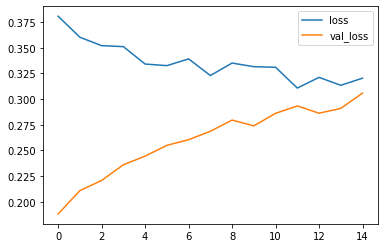

In [39]:
# Loss plots

plt.plot(fin_model2_history.history['loss'])
plt.plot(fin_model2_history.history['val_loss'])
plt.legend(['loss','val_loss'])

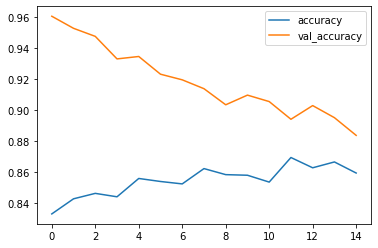

In [40]:
# Accuracy plots

plt.plot(fin_model2_history.history['accuracy'])
plt.plot(fin_model2_history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])

In [41]:
# Test Set Evaluation
final_model2.evaluate(x=test_data2,y=test_y_label2,batch_size=8,verbose=2)

301/301 - 0s - loss: 0.3879 - accuracy: 0.8293 - 318ms/epoch - 1ms/step


[0.3878585994243622, 0.8293089270591736]

In [42]:
y_pred2 = np.round(final_model2.predict(test_data2))
y_pred2

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

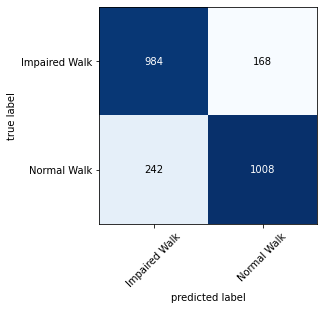

In [43]:
# Confusion Matrix plot
conf_mat2 = confusion_matrix(test_y_label2,y_pred2)
plot_confusion_matrix(conf_mat2,class_names=["Impaired Walk","Normal Walk"])

In [44]:
Acc_S2 = accuracy_score(test_y_label2,y_pred2)
print(Acc_S2)

0.829308909242298


In [45]:
print(f'The NN performs using Smart phone 1 data with Testset Accuracy of {np.round(Acc_S1*100,2)}\n & using Smartphone 2 data with Testset Accuracy of {np.round(Acc_S2*100,2)}')

The NN performs using Smart phone 1 data with Testset Accuracy of 83.31
 & using Smartphone 2 data with Testset Accuracy of 82.93


# F-Score

In [49]:
f1_score(test_y_label2,y_pred2, average='binary')

0.8309975267930749

In [50]:
f1_score(test_y_label,y_pred, average='binary')

0.8372445117335351

# Plots

In [16]:
filepath1 = 'Subject_253_impaired1'
acc_file  = filepath1 + '/Accelerometer.csv'
gyro_file = filepath1 + '/Gyroscope.csv'

acc_data  = pd.read_csv(acc_file)
acc_data = acc_data.dropna(axis=0)


gyro_data = pd.read_csv(gyro_file)
gyro_data = gyro_data.dropna(axis=0)



acc = acc_data.iloc[:,1:4].values.astype(float)
gyro = gyro_data.iloc[:,1:4].values.astype(float)

fs = np.round(len(acc_data)/(acc_data.iloc[-2,0]-acc_data.iloc[0,0]))


filt_acc = filter_data(acc,fs)
filt_gyro = filter_data(gyro,fs)

cut_acc,cut_gyro = cut_data(filt_acc,filt_gyro,fs)
mod_acc,mod_gyro = rot(cut_acc,cut_gyro)


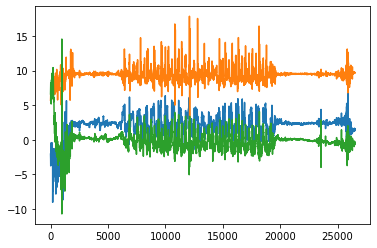

In [23]:
# Raw data plot:
plt.plot(acc_data.iloc[:,1:4])

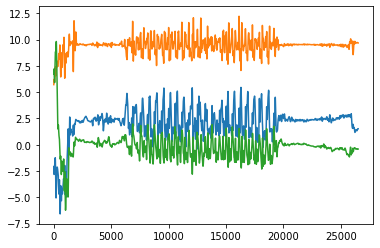

In [24]:
# Filtered data plot:
plt.plot(filt_acc)

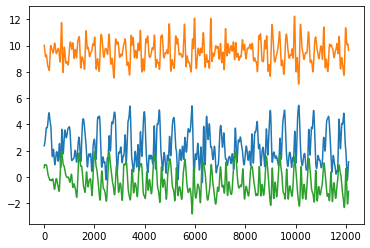

In [27]:
# Cropped data points:
plt.plot(cut_acc)

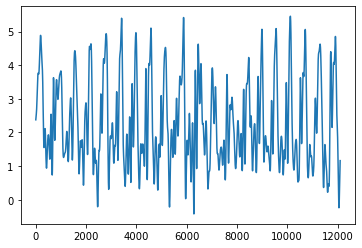

In [28]:
# Cropped data points for Accelerometer in X-direction
plt.plot(cut_acc[:,0])

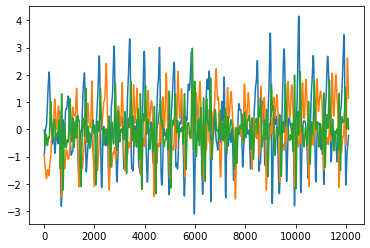

In [33]:
# Rotated data of Accelerometer:
plt.plot(mod_acc)

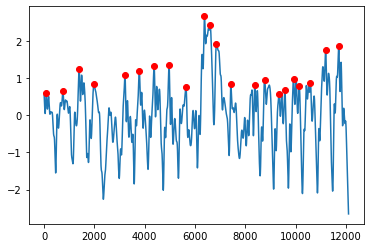

In [35]:
# Peaks plot of gyroscope data:
med        = np.median(mod_gyro[:,1])
std        = np.std(mod_gyro[:,1])
height     = round(med+0.5*std,2)

#print(str(fs) + ' is  the sampling freq')
peaks,_    = signal.find_peaks(mod_gyro[:,1],height=height,distance=fs/2)

plt.plot(mod_gyro[:,1])
plt.plot(peaks,mod_gyro[:,1][peaks],'ro')